Starting Portfolio Value: 100000.00
BUY 327586 shares at 0.29
1999-02-05, BUY EXECUTED, 0.30
SELL shares at 0.31
1999-02-12, SELL EXECUTED, 0.30
BUY 364666 shares at 0.26
1999-03-18, BUY EXECUTED, 0.27
SELL shares at 0.28
1999-03-31, SELL EXECUTED, 0.28
BUY 363285 shares at 0.27
1999-04-19, BUY EXECUTED, 0.28
SELL shares at 0.32
1999-04-27, SELL EXECUTED, 0.33
BUY 338625 shares at 0.34
1999-05-17, BUY EXECUTED, 0.34
SELL shares at 0.36
1999-06-03, SELL EXECUTED, 0.36
BUY 337059 shares at 0.36
1999-06-18, BUY EXECUTED, 0.35
SELL shares at 0.36
1999-07-01, SELL EXECUTED, 0.36
BUY 303209 shares at 0.41
1999-07-21, BUY EXECUTED, 0.42
SELL shares at 0.46
1999-08-12, SELL EXECUTED, 0.46
BUY 282467 shares at 0.48
1999-08-31, BUY EXECUTED, 0.48
SELL shares at 0.53
1999-09-02, SELL EXECUTED, 0.52
BUY 251810 shares at 0.58
1999-09-14, BUY EXECUTED, 0.58
SELL shares at 0.58
1999-10-18, SELL EXECUTED, 0.57
BUY 251548 shares at 0.57
1999-10-19, BUY EXECUTED, 0.55
SELL shares at 0.6
1999-10-29, SELL

SELL shares at 71.44
2020-04-15, SELL EXECUTED, 70.28
BUY 61201 shares at 70.38
2020-04-20, BUY EXECUTED, 69.18
SELL shares at 73.12
2020-05-01, SELL EXECUTED, 71.24
BUY 57560 shares at 76.77
2020-05-14, BUY EXECUTED, 75.99
SELL shares at 81.13
2020-06-04, SELL EXECUTED, 80.95
BUY 53357 shares at 87.74
2020-06-18, BUY EXECUTED, 87.69
SELL shares at 91.47
2020-06-24, SELL EXECUTED, 91.09
BUY 54899 shares at 88.25
2020-06-29, BUY EXECUTED, 88.15
SELL shares at 95.58
2020-07-10, SELL EXECUTED, 95.16
BUY 53711 shares at 96.83
2020-07-22, BUY EXECUTED, 96.52
SELL shares at 106.07
2020-08-03, SELL EXECUTED, 108.01
BUY 50403 shares at 114.61
2020-08-18, BUY EXECUTED, 114.35
SELL shares at 124.37
2020-08-24, SELL EXECUTED, 128.70
Final Portfolio Value: 6791826.96


<IPython.core.display.Javascript object>


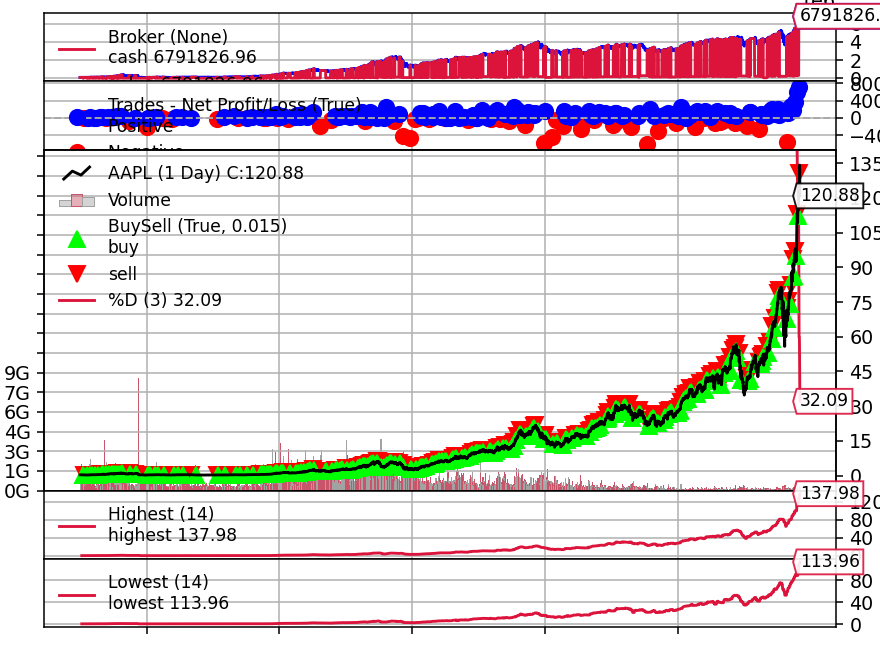

In [36]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import math 

# Import the backtrader platform
import backtrader as bt

class StochasticOscillator(bt.Strategy) :
    params =(('periodK',14),('periodD',3),('percent',0.95))
    
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
    
    def __init__ (self) :
        self.highest = bt.indicators.Highest(self.data.high, period = self.params.periodK)
        self.lowest = bt.indicators.Lowest(self.data.low, period = self.params.periodK)
        self.k = (self.data.close[0] - self.lowest) * 100 / (self.highest - self.lowest)
        self.d = bt.indicators.SMA(self.k, period = self.params.periodD, plotname = '%D') 
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
    
    def next(self) :
        if not self.position and self.k > self.d and self.data.close[0] < self.data[-1]  :
            self.numShares = math.floor(self.broker.cash * self.params.percent/self.data.close)
                
            print("BUY {} shares at {}".format(self.numShares,self.data.close[0]))
            self.buy(size = self.numShares)
        
        if self.position and self.k < self.d and self.data.close[0] > self.data[-1] and self.data.close[-1] > self.data[-2] :
            print('SELL shares at {}'.format(self.data.close[0]))
            self.close()                

if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(StochasticOscillator)
    name = ['orcl-1995-2014.txt','nvda-1999-2014.txt','yhoo-1996-2014.txt','AAPL.txt']

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname= name[3],
        # Do not pass values before this date
        fromdate=datetime.datetime(1999, 1, 1),
        # Do not pass values before this date
        todate=datetime.datetime(2014, 12, 31),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)
    cerebro.broker.setcommission(commission=0.001)
    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    cerebro.plot()

Adding the extra condition that compares data.close[-1] and data.close[-2] increases the value oby 2X but decreases AAPL from 6 million to 950k

In [1]:
10+2

12